# Homework 10: Model selection

This homework is designed to give you practice implementing model selection techniques, including best subset selection and forward/backward stepwise selection.

You won't need to load in any data for this homework, we will be simulating our own.

---
## 1. Best subset selection (4 points)

In this question, we will first generate simulated data, and then use it to perform best subset selection.

a) Use `rnorm()` to generate a dataset including a predictor $X$ of length $n = 100$ and a noise vector $\epsilon$ of length $n = 100$. Generate data for a response variable $Y$ of length $n = 100$ according to the model

$Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$

where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice.


,X,Y
,<dbl>,<dbl>
1,0.96889362,107.60359
2,0.68465313,96.33458
3,-2.25118918,-633.29254
4,-0.71234648,-40.82154
5,0.12025792,63.87096
6,-0.07474289,46.68015


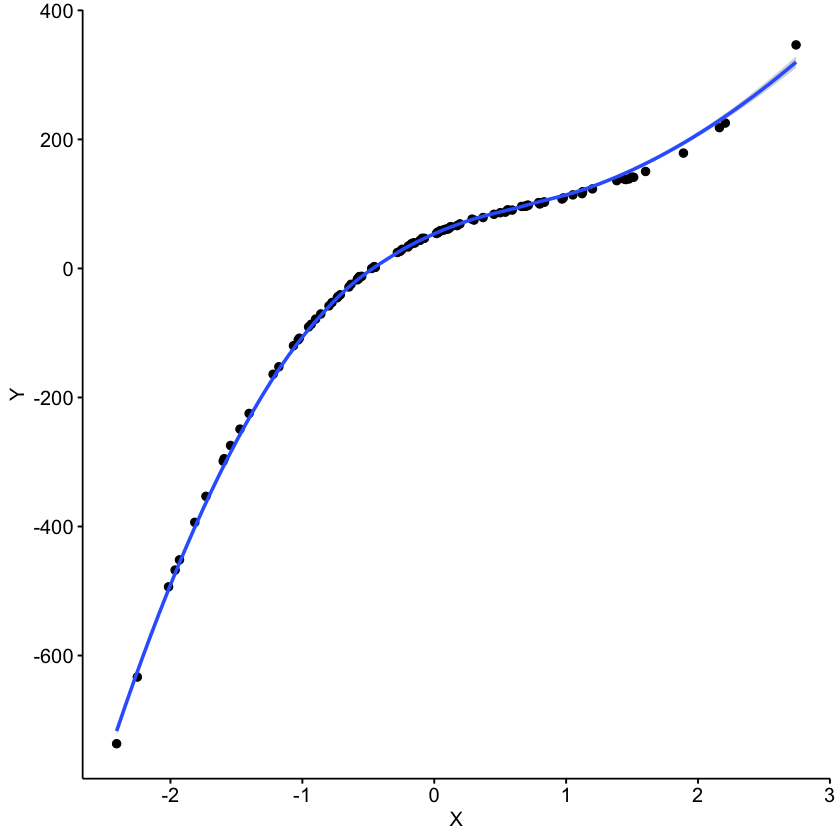

In [2]:
library(ggpubr)
#options(repr.plot.width=5, repr.plot.height=5)

set.seed(111213)

stim.data <- function (n=100,x=rnorm(n=n), b0=54,b1=86,b2=-50,b3=21, err= rnorm(n=n)){
    y <- b0 + b1*x + b2*x^2 + b3*x^3 + err
    return(data.frame(X=x, Y=y ))
}

dat <- stim.data()
head(dat)

# Visualize the data
dat %>% ggscatter("X", "Y") + geom_smooth(method = 'loess', formula = 'y~x') 
# taking a moment of silence to appreciate that this was a result of using google to generate numbers for my constant
# i will never have actual data that fits this nicely 

b) Use `regsubsets()` to perform best subset selection to determine the best model that contains the predictor variables $X$, $X^2$, . . . , $X^{10}$. Print the model summary.

For this you will need to install and load the _leaps_ library.

In [65]:
suppressMessages(library(leaps))
set.seed(111213)
for(i in 2:10){
    dat[paste0("X^",i)] <- dat$X^i
}
head(dat)

reg.full <-regsubsets(Y~., dat)
reg.summary<-summary(reg.full)
reg.summary

,X,Y,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.96889362,107.60359,0.93875484,9.095536e-01,8.812606e-01,8.538478e-01,8.272877e-01,8.015538e-01,7.766203e-01,7.524625e-01,7.290561e-01
2,0.68465313,96.33458,0.46874990,3.209311e-01,2.197265e-01,1.504364e-01,1.029968e-01,7.051706e-02,4.827972e-02,3.305486e-02,2.263112e-02
3,-2.25118918,-633.29254,5.06785273,-1.140870e+01,2.568313e+01,-5.781759e+01,1.301583e+02,-2.930110e+02,6.596232e+02,-1.484937e+03,3.342873e+03
4,-0.71234648,-40.82154,0.50743751,-3.614713e-01,2.574928e-01,-1.834241e-01,1.306615e-01,-9.307627e-02,6.630256e-02,-4.723039e-02,3.364440e-02
5,0.12025792,63.87096,0.01446197,1.739166e-03,2.091485e-04,2.515177e-05,3.024699e-06,3.637440e-07,4.374310e-08,5.260454e-09,6.326113e-10
6,-0.07474289,46.68015,0.00558650,-4.175512e-04,3.120898e-05,-2.332649e-06,1.743490e-07,-1.303135e-08,9.740005e-10,-7.279961e-11,5.441254e-12


Subset selection object
Call: regsubsets.formula(Y ~ ., dat)
10 Variables  (and intercept)
       Forced in Forced out
X          FALSE      FALSE
`X^2`      FALSE      FALSE
`X^3`      FALSE      FALSE
`X^4`      FALSE      FALSE
`X^5`      FALSE      FALSE
`X^6`      FALSE      FALSE
`X^7`      FALSE      FALSE
`X^8`      FALSE      FALSE
`X^9`      FALSE      FALSE
`X^10`     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         X   `X^2` `X^3` `X^4` `X^5` `X^6` `X^7` `X^8` `X^9` `X^10`
1  ( 1 ) "*" " "   " "   " "   " "   " "   " "   " "   " "   " "   
2  ( 1 ) "*" "*"   " "   " "   " "   " "   " "   " "   " "   " "   
3  ( 1 ) "*" "*"   "*"   " "   " "   " "   " "   " "   " "   " "   
4  ( 1 ) "*" "*"   "*"   "*"   " "   " "   " "   " "   " "   " "   
5  ( 1 ) "*" "*"   "*"   "*"   " "   "*"   " "   " "   " "   " "   
6  ( 1 ) "*" "*"   "*"   "*"   "*"   " "   " "   " "   "*"   " "   
7  ( 1 ) "*" "*"   "*"   "*"   "*"   "*"   "*"   " "   " "   "

c) Plot the Mallows' Cp, Bayesian Information Criteria (BIC) and the adjusted coefficient of determination, $R^2$, for each model tested. Which is the best model? Report the coefficients of the best model. 

In [3]:
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
suppressMessages(library(ggpubr))

In [55]:
#Avital shared this lovely function to plot all the bias-adjusted model evaluations

plot_sum <- function(sum_object) {
  numvar = 1:length(sum_object$rss)
  
  #mallow's cp
  cp.df <- tibble(
    numvar = numvar,
    cp = sum_object$cp,
    mincp = if_else(numvar == which.min(sum_object$cp), TRUE, FALSE)
  )
  
  p.cp <- ggplot(cp.df, aes(
    x = numvar,
    y = cp,
    shape = mincp,
    col = mincp
  )) +
    geom_point(size = 3) +
    theme_light() +
    labs(
      x = "Number of Variables",
      y = "Mallow's CP",
      color = "Minimum CP",
      shape = "Minimum CP"
    ) + 
    theme(legend.position = "top", aspect.ratio = 1) +
    scale_x_continuous(breaks = numvar)
  
  
  
  #Bayesian Information Criteria
  bic.df <- tibble(
    numvar = numvar,
    bic = sum_object$bic,
    minbic = if_else(numvar == which.min(sum_object$bic), TRUE, FALSE)
  )
  
  p.bic <- ggplot(bic.df, aes(
    x = numvar,
    y = bic,
    shape = minbic,
    col = minbic
  )) +
    geom_point(size = 3) +
    theme_light() +
    labs(
      x = "Number of Variables",
      y = "BIC",
      color = "Minimum BIC",
      shape = "Minimum BIC"
    ) + 
    theme(legend.position = "top", aspect.ratio = 1) +
    scale_x_continuous(breaks = numvar)
  
  #Adjusted R^2
  adjr2.df <- tibble(
    numvar = numvar,
    adjr2 = sum_object$adjr2,
    maxadjr2 = if_else(numvar == which.max(sum_object$adjr2), TRUE, FALSE)
  )
  
  p.adjr2 <- ggplot(adjr2.df,
                    aes(
                      x = numvar,
                      y = adjr2,
                      shape = maxadjr2,
                      col = maxadjr2
                    )) +
    geom_point(size = 3) +
    theme_light() +
    labs(
      x = "Number of Variables",
      y = "Aj" ~ R ^ 2,
      color = "Maximum Adjusted" ~ R ^ 2,
      shape = "Maximum Adjusted" ~ R ^ 2
    ) + 
    theme(legend.position = "top", aspect.ratio = 1) +
    scale_x_continuous(breaks = numvar)
  
  ggarrange(p.cp, p.bic, p.adjr2, nrow = 1) %>% return
  
}

           A B  C  D  E  F 
Mallows Cp x x2 x3 x4 x5 x9
BIC        x x2 x3         
R^2        x x2 x3 x4 x5 x9

[1] "Regression coefficients for the 6 variable model: Y = 85.538*X + -49.626*`X^2` + 21.689*`X^3` + -0.087*`X^4` + -0.165*`X^5` + 0.002*`X^9`"
[1] "Regression coefficients for the 3 variable model: Y = 86.128*X + -50.014*`X^2` + 20.982*`X^3`"
[1] "Regression coefficients for the 4 variable model: Y = 86.063*X + -49.74*`X^2` + 21.012*`X^3` + -0.055*`X^4`"


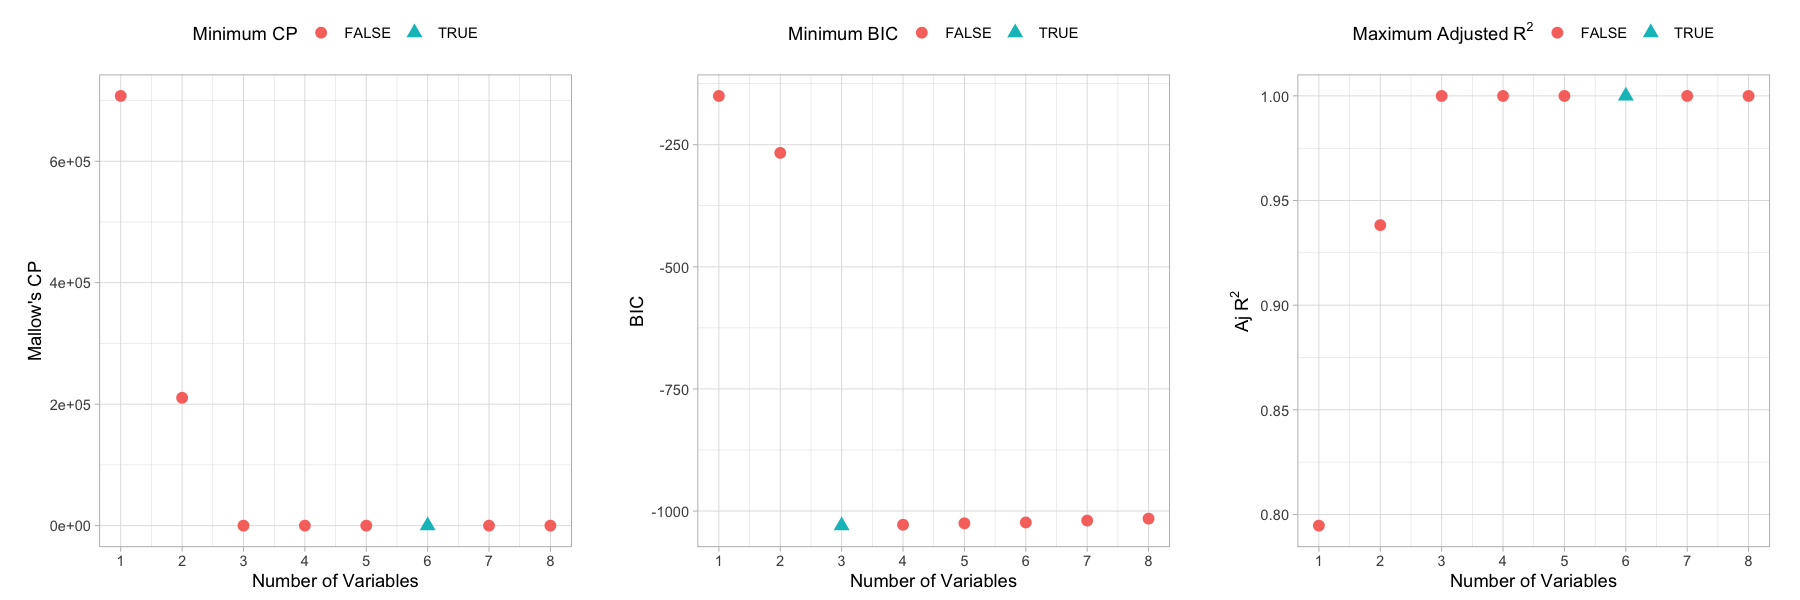

In [91]:
options(repr.plot.width=15, repr.plot.height=5)
plot_sum(reg.summary)
#par(mfrow=c(1,3))
#plot(models,scale="Cp") # 4 variables
#plot(models,scale="bic") # 2 variables
#plot(models,scale="adjr2") #5 variables

cp_coef <- which.min(reg.summary$cp) 
bic_coef <- which.min(reg.summary$bic)
r2_coef <-  which.max(reg.summary$adjr2)
#coef(reg.full,cp_coef) # x3,x6,x7,x9
#coef(reg.full,bic_coef) #x3,x5
#coef(reg.full,r2_coef) #x2,x3,x4,x5,x10

#created a simple table to keep track of the coefficents
exh_list <-matrix(c("x","x2","x3","x4","x5","x9",
                    "x","x2","x3","","","",
                    "x","x2","x3","x4","x5","x9"), nrow=3, byrow = TRUE)
rownames(exh_list) <-c('Mallows Cp', 'BIC', 'R^2')
exh_list<-as.table(exh_list)
exh_list

#Got this code from Avital to extract the formulas
get.coefs <- function(subset, models){
  for (i in models) {
    coeffs <- coef(subset, id = i)[-1] %>% round(3)
    b <- coeffs %>% as.numeric
    v <- coeffs %>% names
    paste(b, v, sep = "*") %>%
      paste(., collapse = " + ") %>%
      paste0("Regression coefficients for the ", i, " variable model: Y = ", .) %>% print
  }
}

get.coefs(reg.full, c(6, 3,4))



In [93]:
#reg.summary$cp[which.min(reg.summary$cp)]
#reg.summary$bic[which.min(reg.summary$bic)]
#reg.summary$adjr2[which.max(reg.summary$adjr2)]

# Decided to look at all the values for evaluations since in the graphs, so many are plotted around the same value. 
# so the difference between them probably wasn't that great (and it wasn't)

#reg.summary$cp
#reg.summary$adjr2
#reg.summary$bic

> *Write your response here* 
>
> At first glance, Both **Mallows' Cp** and **Adjusted** $R^2$ evaluations agree on the 6 variable model with the following coeffiecients:
>
>$$Y = 85.538*X + -49.626*X^2 + 21.689*X^3 + -0.087*X^4 + -0.165*X^5 + 0.002*X^9$$
>
> While, according to BIC metrics, the model 3 variable model was the best. $Y = 86.128*X + -50.014*X^2 + 20.982*X^3$
>
> If we do some further probing, and look at the evaluation values for all 8 models, the Mallows' Cp value for this 
model 6, 4.63, is not close to *p* + 1 which indicates this may not be the best model (compared to the model with 5 variables which has a Mallows' Cp value of 5.29 which is close to *p* + 1 and the model with 4 variables where the value is 4.79). Similarly with Adjusted $R^2$, even though model 6 has a value of .99, so does model 3-8. 
>
> Given this information, I would say that perhaps the best model is **model 4** (the model with 4 variables) with a Mallows' Cp of 4.79, Adjusted $R^2$ of .99, and a BIC of -1028.
>
>$$Y = 86.063*X + -49.74*X^2 + 21.012*X^3 + -0.055*X^4$$
>
>I know it is possible to varify which is the best model using cross-validation, however in the sake of time, I choose to simply report all the models with my own prediction that model 4 is the best.

---
## 2. Forward and backwards stepwise selection (3 points)

Using the same simulated data from question 1, use forward stepwise selection, and backwards stepwise selections to determine the best model. Again, for both model selection methods, plot the Mallows' Cp, Bayesian Information Criteria (BIC) and the adjusted coefficient of determination, $R^2$, for each model tested. Report the coefficients of the best model. 

a) Forward stepwise selection:

[1] "Regression coefficients for the 4 variable model: Y = 86.063*X + -49.74*`X^2` + 21.012*`X^3` + -0.055*`X^4`"
[1] "Regression coefficients for the 3 variable model: Y = 86.128*X + -50.014*`X^2` + 20.982*`X^3`"
[1] "Regression coefficients for the 7 variable model: Y = 85.553*X + -49.359*`X^2` + 21.698*`X^3` + -0.24*`X^4` + -0.205*`X^5` + 0.02*`X^6` + 0.016*`X^7`"


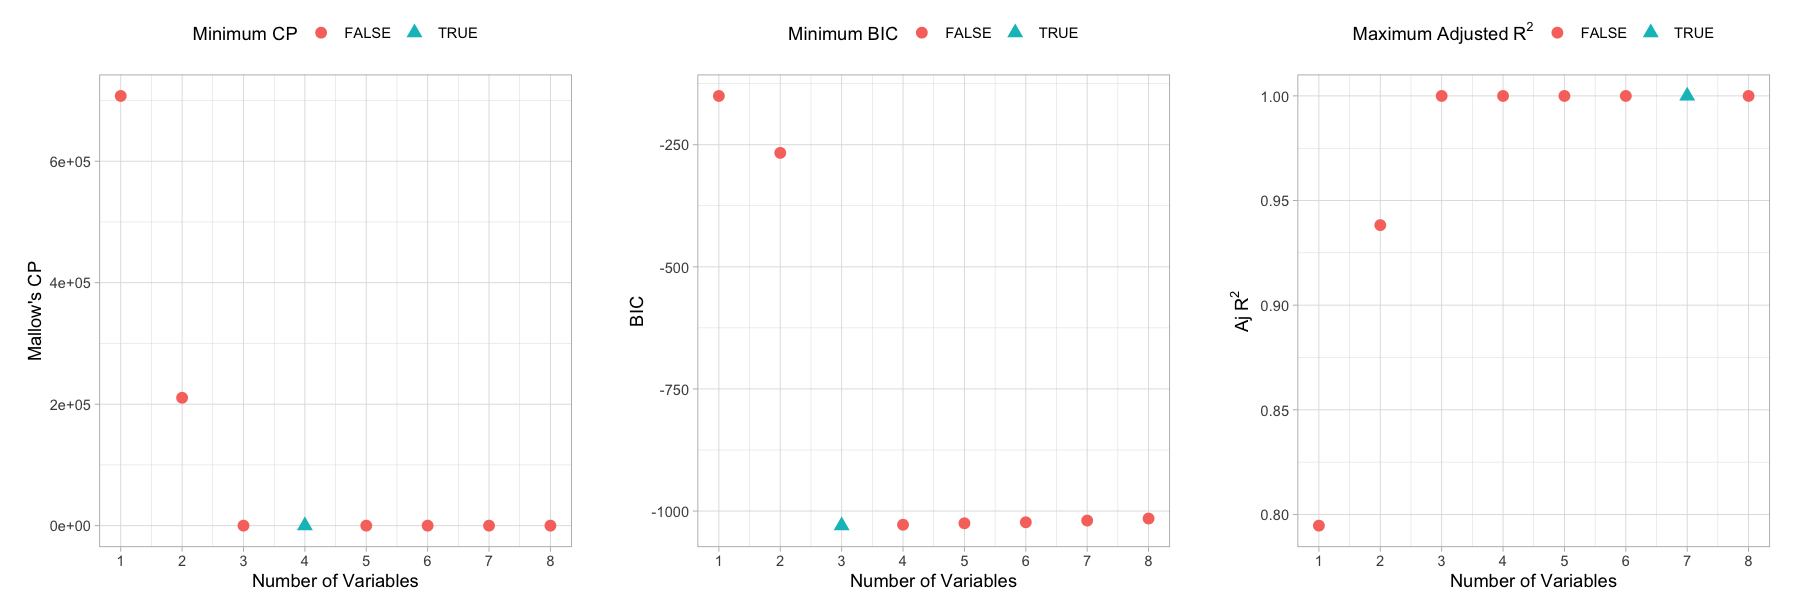

In [99]:
regfit_fwd <-regsubsets(Y~., dat, method="forward")
fwd.summary <- summary(regfit_fwd)
plot_sum(fwd.summary)

#manually extracting coefficients
cp_fwd <- which.min(fwd.summary$cp) 
bic_fwd <- which.min(fwd.summary$bic)
r2_fwd <-  which.max(fwd.summary$adjr2)
#coef(regfit_fwd,cp_fwd)  #x,x2,x3,x4
#coef(regfit_fwd,bic_fwd) #x,x2,x3
#coef(regfit_fwd,r2_fwd)  #x,x2,x3,x4,x5,x6,x7

get.coefs(reg.full, c(4,3,7))

#fwd.summary$cp
#fwd.summary$adjr2
#fwd.summary$bic


b) Backwards stepwise selection:

[1] "Regression coefficients for the 6 variable model: Y = 85.538*X + -49.626*`X^2` + 21.689*`X^3` + -0.087*`X^4` + -0.165*`X^5` + 0.002*`X^9`"
[1] "Regression coefficients for the 3 variable model: Y = 86.128*X + -50.014*`X^2` + 20.982*`X^3`"


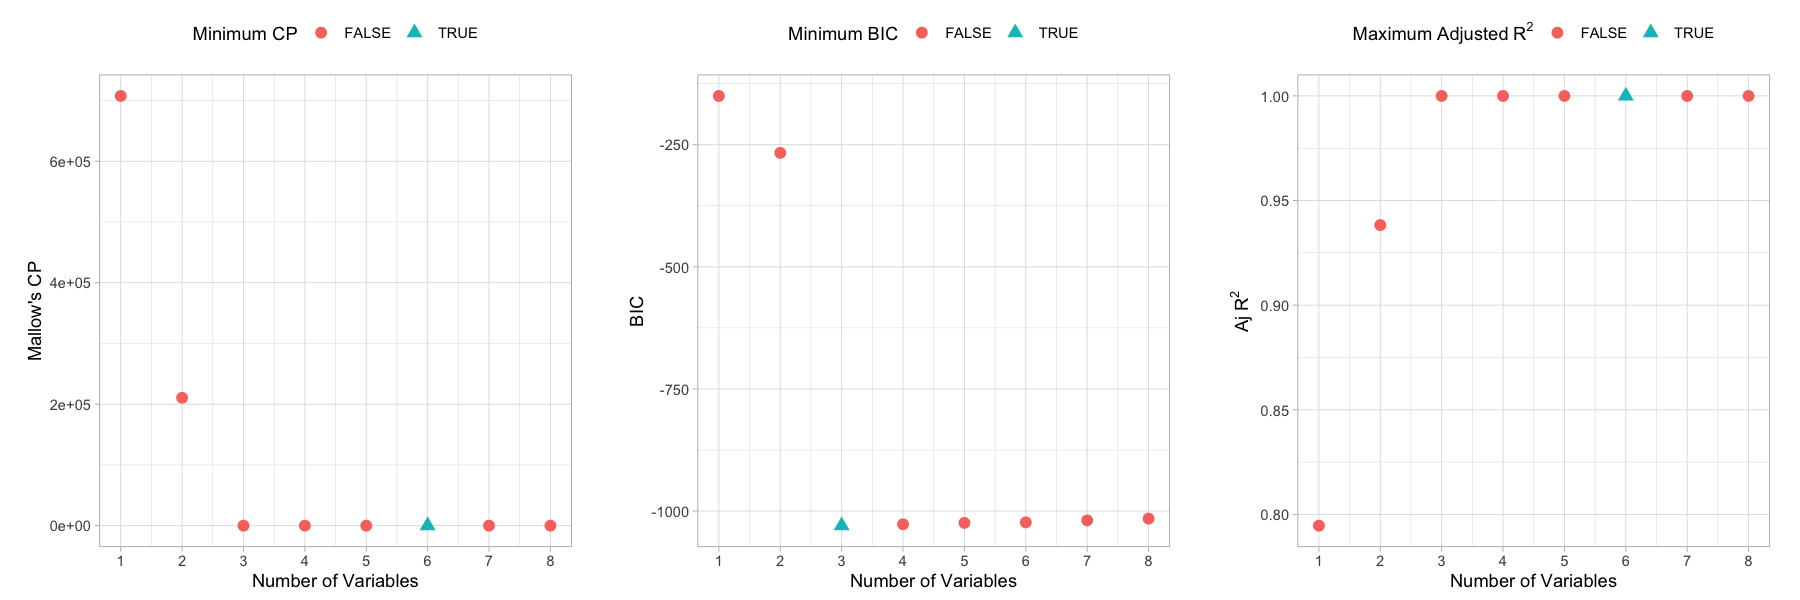

In [98]:
regfit_bwd <-regsubsets(Y~., dat, method="backward")
bwd.summary <-summary(regfit_bwd)

plot_sum(bwd.summary)

cp_bwd <- which.min(bwd.summary$cp) 
bic_bwd <- which.min(bwd.summary$bic)
r2_bwd <-  which.max(bwd.summary$adjr2)
#coef(regfit_bwd,cp_bwd) # x,x2,x3,x5,x6,x8
#coef(regfit_bwd,bic_bwd) #x,x2,x3
#coef(regfit_bwd,r2_bwd) #x,x2,x3,x5,x6,x8

get.coefs(reg.full, c(6,3))

#bwd.summary$cp
#bwd.summary$adjr2
#bwd.summary$bic

c) Compare your results from parts a and b with those of question 1.

> *Write your response here* 
>
> The results from the exhaustive algorithm and the backward selection method were the same. In each method, there was a concensus between Mallows' Cp and Adjusted $R^2$ on the model with 6 variables. And in both these methods, the BIC metrics indicated the model with 3 variables was the best. The forward selection method results deviated completed from the results of the other two methods. Additionally, there were no agreements between any of the evaluations. 
>
> However, again these were the results at first glance. Similar to question 1, looking at our plots, most of the models are plotted around the same value (it is really the model with 1 and 2 variables that deviated the most from the rest.) Thus by looking at all the values, it again seems that **model 4** across all the methods is the best model.
>
>$$  Y = 86.128*X + -50.014*X^2 + 20.982*X^3 $$
>
> **Exhuastive Algorithm**: Mallows' Cp of 4.79, Adjusted $R^2$ of .99, and a BIC of -1028
>
> **Forward Selection**: Mallows' Cp of 4.79, Adjusted $R^2$ of .99, and a BIC of -1028
>
> **Backward Selection**: Mallows' Cp of 5.71, Adjusted $R^2$ of .99, and a BIC of -1027 (however I will note that in the backward selection, model 5 had a value of 6.05 which is closest to the number of predictors plus the constant.)

---
## 3. Training and test error (3 points)

This question will explore the relationship between training and test error and the number of features included in a model. We will again use a simulated dataset. 

a) Simulate dataset with features $p = 20$ and observations $n = 1,000$. Generate data for a response variable $Y$ according to the model

$Y = X\beta + \epsilon$ 

where $\beta$ is random with some elements that are exactly zero.

Split your simulated dataset into a training set containing $n=100$ observations and a test set containing $n=900$ observations.

In [129]:
set.seed(3)

n <- 1000
p <- 20

#After this step this set up was difficult to do on my own and Avital was kind enough to show what she did. I 
# have placed comments next to the line of code though to make sure I am understanding what is happening

#naming x variable up to p times
xnames <- paste0("x", 1:p) 

#generating betas with runif, with 10 of them set to 0
betas <- c(runif(10,1,10), rep(0, 10)) %>% round(2) %>% sample 

eps <- rnorm(n,0,.1) #generating error term

#creating vector set in the format of betas*x+, but right not is a character string
yformula <- paste0(betas, "*", xnames) %>% paste0(., collapse = "+") 

#taking 100 rows from our sample n to train
train_set <- sample(n, 100)

#creating the df
df <- matrix(nrow = n, ncol = p, dimnames = list(1:n, xnames)) %>%  #naming our columns
  as.data.frame() %>% 
  mutate(across(everything(), ~rnorm(n))) %>% #this is saying across all columns, apply rnorm for length n
  mutate(y=eval(parse(text = yformula))+ eps) #turning the character string into an expression and setting y to be the 
                                                # evaluation of that expression 

train <- df[train_set,] #subsetting train set
test <- df[-train_set,] #remaing rows 


b) Perform best subset selection on the training set, and plot the associated training and test set MSE for the best model of each size.

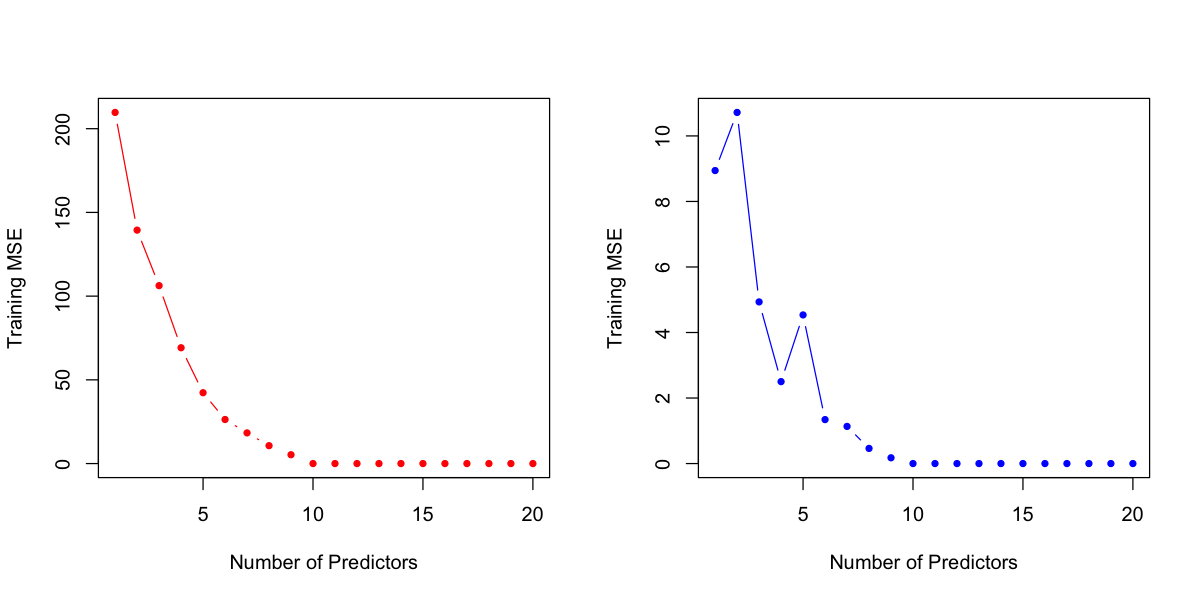

In [191]:
options(repr.plot.width=10, repr.plot.height=5)

train_models <- regsubsets(y~.,train,nvmax = 20)
train.summary <-summary(train_models)

# got additional help from Delainey W. for this question as well as Avital

#training set
train.mat <- model.matrix(y ~ ., data = train)
train_errors <- rep(NA, 20)


for (i in 1:p) {
  coefi = coef(train_models, id=i)
  pred = train.mat[,names(coefi)]%*%coefi
  train_errors[i] = mean((pred - train$y)^2)
}


#Plot the training MSE
par(mfcol=c(1,2))
plot(train_errors,
     xlab="Number of Predictors", 
     ylab="Training MSE",
     pch=20,
     type="b",
     col="red") 

#test set
test_errors <- rep(NA, 20)
test.matrix <- model.matrix(y ~ ., data = test)

for (i in 1:p) {
  coefi <- coef(train_models, id = i)
  pred <- test.matrix[,names(coefi)]%*%coefi
  test_errors[i] <- mean(test$y-pred)^2
}

#plot the test MSE

plot(test_errors,
     xlab="Number of Predictors",
     ylab="Training MSE",
     pch=20,
     type="b",
     col="blue")



c) Identify the best model according the test MSE. How does this model compare to the actual model used to simulate the dataset?

*Note: If the model identified contains only an intercept or all of the features, then generate a new dataset (i.e. repeat part a with a different random seed) until the test set MSE is minimized for an intermediate model size.*

In [199]:
which.min(test_errors)
best<-coef(train_models, id = 10)[-1]
actual = betas[which(!betas %in% 0)]
tibble(Best=best,
Actual=actual)

print(paste("difference:",mean(best-actual)))



[1] 10

Best,Actual
<dbl>,<dbl>
6.691756,6.68
3.668977,3.65
6.418180,6.42
8.277917,8.27
2.514330,2.51
6.457070,6.44
3.965918,3.95
2.129178,2.12
6.217312,6.20


[1] "difference: 0.0110099922886716"


> *Write your response here* 
>
> The best model according to the test MSE is the one with 10 variables. Comparing this model to the actual model, the values are close with average difference of .01 between them.

**DUE:** 5pm EST, April 15th, 2022

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Danielle F., Avital P. (life saver), Delainey W.*